## Training: Learning Rates

The learning rate is one of the most important hyperparameters when training a neural network. In general, the optimal learning rate is about half of the maximum learning rate (i.e., the learning rate above which the training algorithm diverges - that is, where it's performance begins to suffer). One way to find a good learning rate is to train the model for a few hundred iterations, starting with a very low learning rate (e.g., $10^{–5}$) and gradually increasing it up to a very large value (e.g., 10). This is done by multiplying the learning rate by a constant factor at each iteration (e.g., to go from $10^{–5}$ to 10 in 500 iterations). 

If you plot the loss as a function of the learning rate (using a log scale for the learning rate), you should see it dropping at first. But after a while, the learning rate will be too large, so the loss will shoot back up: the optimal learning rate will be a bit lower than the point at which the loss starts to climb (typically about 10 times lower than the turning point). You can then reinitialize your model and train it normally using this good learning rate.  Here's how to do this in code.

In [1]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 3.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 45.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 48.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 32.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 1.3 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 7.6 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 48.7

In [1]:
# Using Fashion MNIST as a working example
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

2024-04-11 15:01:42.314459: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-11 15:01:42.317492: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-11 15:01:42.355072: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 15:01:44.367857: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


**Step 1:  Increasing the learning rate**

The following callback increases the learning rate by a factor in each batch, and also keeps track of the losses.  This is a little kludgey because keras only reports mean loss (over all batches thus far) so we need to keep track of things to figure out how much loss is incurred by each batch. 

In [3]:
import math
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far 
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        self.model.optimizer.learning_rate = self.model.optimizer.learning_rate * self.factor

**Step 2: Probing the model**

The following routine trains a model using the above callback to update the learning rate through a range of values, and then resets the model when done.

In [4]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    model.optimizer.learning_rate = min_rate
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    model.optimizer.learning_rate = init_lr
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

**Step 3: Inspecting the data**

Finally, we simply plot the losses against the learning rate to identify a "peak" and then we'll back off from there.

In [5]:
import matplotlib.pyplot as plt

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

Now we build the model and find the optimal learning rate.

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2024-04-11 15:02:32.893454: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.


430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2337 - loss: 2.1521


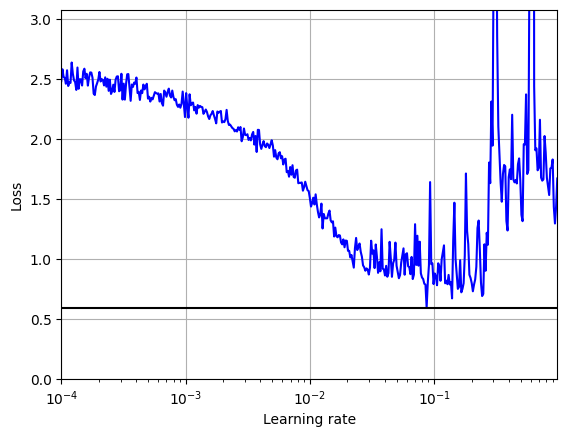

In [6]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

This suggests an optimal learning rate around $ 10^{-1} $.  So, let's give it a try.

In [6]:
optimal_lr = 0.1
optimizer = tf.keras.optimizers.SGD(learning_rate=optimal_lr)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,metrics=["accuracy"])
history_optimal_lr = model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

Epoch 1/10


2024-04-09 16:03:01.880063: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.


1679/1719 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7299 - loss: 0.7349

2024-04-09 16:03:05.901998: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15680000 exceeds 10% of free system memory.


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7314 - loss: 0.7305 - val_accuracy: 0.8046 - val_loss: 0.5177
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8497 - loss: 0.4125 - val_accuracy: 0.8370 - val_loss: 0.4126
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8678 - loss: 0.3634 - val_accuracy: 0.8604 - val_loss: 0.3708
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8763 - loss: 0.3350 - val_accuracy: 0.8564 - val_loss: 0.3767
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8838 - loss: 0.3148 - val_accuracy: 0.8570 - val_loss: 0.3750
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8904 - loss: 0.2968 - val_accuracy: 0.8634 - val_loss: 0.3676
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8949 - loss: 0.2823 - val_accuracy: 0.8640 - val_loss: 0.3665
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8976 - loss: 0.2743 - val_accurac

### Exercise

Verify that 0.1 is a better learning rate than something much smaller (e.g. .001) or much larger (e.g., .5).

### Learning Rate Schedules

A constant learning rate doesn't account for the possibility that the gradient landscape changes as we move across it.  Optimizers can help address this, but it is also possible to adjust the learning rate according to a schedule.  In the following, we discuss a few approaches for this.

#### Motivation?

1. **Early Training:** Initially, a larger learning rate can be beneficial, enabling rapid learning and helping the model to quickly escape suboptimal local minima.
2. **Later Stages:** As training progresses, reducing the learning rate helps to stabilize the learning process and fine-tune the model parameters, leading to better convergence.
3. **Preventing Overfitting and Oscillations:** A carefully chosen learning rate schedule can prevent the model from overfitting and reduce oscillations near the minima.

<div style="text-align: center">

![learning rate](assets/learning_rate.png)
</div>

Learning rate scheduling is thus a balancing act - starting with a higher learning rate for faster convergence initially, then decreasing it to allow more fine-grained adjustments as the model starts converging.

### Methods

1. **Power Scheduling:**
   - **Description:** Gradually decreases the learning rate over time using a polynomial decay, typically quadratic.
   - **Formulation:** $ \eta(t) = \eta_0 / (1 + t/s)^c $, where $ \eta_0 $ is the initial learning rate, $ t $ is the iteration number, $ s $ is a step parameter, and $ c $ is the power, often set to 1.


In [2]:
# Keras supports learning rate scheduling by extending the LearningRateSchedule class, and then passing that to a optimizer.  To implement a PowerSchedule, we can do the following:

class PowerScheduling(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, decay_rate, step_param):
        super(PowerScheduling, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.decay_rate = decay_rate
        self.step_param = step_param

    def __call__(self, step):
        # Note the "cast" here - necessary to make sure we get the correct type back
        return self.initial_learning_rate / (1 + tf.cast(step, tf.float32) / self.step_param) ** self.decay_rate


# Example usage
initial_learning_rate = 0.1
decay_rate = 1.0  # For linear decay
step_param = 1000.0  # Determines how quickly the learning rate decreases

lr_schedule = PowerScheduling(initial_learning_rate, decay_rate, step_param)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
history_power_scheduling = build_and_train_model(optimizer)

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10


2024-04-10 23:12:13.572617: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7369 - loss: 0.7215 - val_accuracy: 0.8312 - val_loss: 0.4454
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8567 - loss: 0.3906 - val_accuracy: 0.8528 - val_loss: 0.3938
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8718 - loss: 0.3484 - val_accuracy: 0.8642 - val_loss: 0.3680
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8805 - loss: 0.3262 - val_accuracy: 0.8710 - val_loss: 0.3529
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8847 - loss: 0.3115 - val_accuracy: 0.8710 - val_loss: 0.3471
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8892 - loss: 0.3009 - val_accuracy: 0.8742 - val_loss: 0.3424
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8923 - loss: 0.2929 - val_accuracy: 0.8758 - val_loss: 0.3367
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8957 - loss: 0.2862 - val_accurac


2. **Exponential Scheduling:**
   - **Description:** Cuts the learning rate by a factor of $ \gamma $ every $ s $ steps.
   - **Formulation:** $ \eta(t) = \eta_0 \cdot \gamma^{t/s} $.
   - **Senior et al's Recommendation:** Particularly recommended for its effectiveness and simplicity in many applications.


In [6]:
import math

# First, we'll calculate a learning rate based on the number of batches we anticipate
n_epochs = 10
batch_size = 32
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)

lr0=.1

# Keras now has an ExponentialDecay scheduling class we can use here
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr0,
                                                             decay_steps=n_steps,
                                                             decay_rate=.95)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
history_exponential_scheduling = build_and_train_model(optimizer)

Optimizer name SGD
Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5548 - accuracy: 0.7962 - val_loss: 0.4356 - val_accuracy: 0.8314
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4015 - accuracy: 0.8519 - val_loss: 0.4274 - val_accuracy: 0.8342
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3577 - accuracy: 0.8673 - val_loss: 0.3823 - val_accuracy: 0.8600
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3333 - accuracy: 0.8764 - val_loss: 0.3678 - val_accuracy: 0.8694
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3159 - accuracy: 0.8821 - val_loss: 0.3414 - val_accuracy: 0.8704
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2994 - accuracy: 0.8884 - val_loss: 0.3738 - val_accuracy: 0.8694
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2887 - accuracy: 0.8904 - val_loss: 0.3


3. **Piecewise Constant Scheduling:**
   - **Description:** Uses a constant learning rate for a set number of epochs and then lowers it to another constant rate for another set of epochs, and so on.
   - **Formulation:** Implementing a pre-defined series of constant learning rates at different training stages.


In [7]:
# Let's say we want a learning rate of .1 for the first 3 epochs, .05 for the next three, and then .005 for the remainder.  So, we'll calculate the number of batches per epoch given our data.
epoch_steps = math.ceil(len(X_train) / batch_size)
b1 = epoch_steps * 3
b2 = b1+epoch_steps * 3


boundaries = [b1, b2]
values = [.1, 0.05, 0.005]
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
history_piecewise = build_and_train_model(optimizer)

Optimizer name SGD
Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.5547 - accuracy: 0.7952 - val_loss: 0.4373 - val_accuracy: 0.8314
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4011 - accuracy: 0.8524 - val_loss: 0.4112 - val_accuracy: 0.8392
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3586 - accuracy: 0.8663 - val_loss: 0.4001 - val_accuracy: 0.8560
Epoch 4/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3060 - accuracy: 0.8870 - val_loss: 0.3397 - val_accuracy: 0.8750
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2924 - accuracy: 0.8913 - val_loss: 0.3216 - val_accuracy: 0.8790
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2800 - accuracy: 0.8951 - val_loss: 0.3353 - val_accuracy: 0.8788
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2471 - accuracy: 0.9077 - val_loss: 0.3


4. **Performance Scheduling:**
   - **Description:** Measures the validation error every $ N $ steps (or epochs) and reduces the learning rate by $ \lambda $ if the error has stopped dropping.
   - **Senior et al's Recommendation:** Advised for its adaptability to the model’s actual progress.


In [17]:
# Performance based scheduling requires the use of a callback, so we can evaluate the performance of the network
# We can do it like this
lr0 = .01
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
history_performance_scheduling = model.fit(X_train, y_train, epochs=25,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 3s 1ms/step - loss: 0.6730 - accuracy: 0.7705 - val_loss: 0.4748 - val_accuracy: 0.8334 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4679 - accuracy: 0.8339 - val_loss: 0.4465 - val_accuracy: 0.8354 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4212 - accuracy: 0.8478 - val_loss: 0.4043 - val_accuracy: 0.8562 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3967 - accuracy: 0.8595 - val_loss: 0.3792 - val_accuracy: 0.8622 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3766 - accuracy: 0.8663 - val_loss: 0.3777 - val_accuracy: 0.8648 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3607 - accuracy: 0.8718 - val_loss: 0.3845 - val_accuracy: 0.8642 - lr: 0.0100
Epoch 7/25
1719/1719 [==============================] - 3s

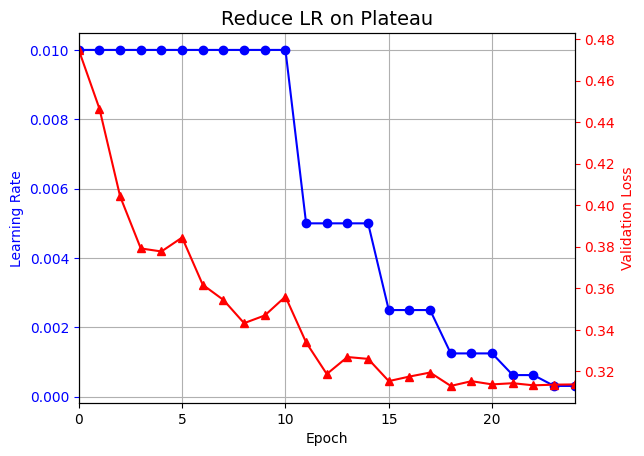

In [18]:
import matplotlib.pyplot as plt

plt.plot(history_performance_scheduling.epoch, history_performance_scheduling.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, 24)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history_performance_scheduling.epoch, history_performance_scheduling.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()


5. **1cycle Scheduling:**
   - **Description:** Briefly increases the learning rate halfway through training before decreasing it. Proposed by [Leslie N. Smith in 2018](https://arxiv.org/abs/1803.09820).
   - **Benefits (Smith, 2018):** Shown to lead to faster convergence and better performance. It allows the model to explore a wider range of parameters due to the higher learning rate in the middle of training.
   - **Formulation:** Starts with a low learning rate, increases it linearly for the first half of training, and then decreases it linearly for the second half, possibly followed by a few epochs with a very small learning rate to finalize training.


Implementing the 1-cycle learning rate scheduler in Keras is not hard, but it requires us to obtain an optimal learning rate first before creating a scheduler.  We did this above.  Here, I'm implementing the LR scheduler as a callback due to some of the complexities of working with tensors.

In [10]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)

In [11]:
import math


model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
batch_size  =32
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs,
                             max_lr=0.1)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle])

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25


2024-04-11 01:24:42.456745: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.


AttributeError: 'str' object has no attribute 'name'



Learning rate scheduling is a powerful tool in the training of neural networks. Different scheduling methods offer various advantages, and the choice of method can depend on the specific characteristics of the task, the dataset, and the desired training dynamics. While 1cycle scheduling has shown promising results for faster convergence, the recommendations of Senior et al. for performance or exponential scheduling highlight the importance of choosing a method that aligns with the model’s learning progress and the practitioner’s familiarity with the training dynamics.